In [1]:
import numpy as np
import os
from os.path import join, exists
import pickle
import geojson
import census_tract_locator
from tqdm import tqdm
import random
import copy
import census_tract_locator
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import shapely

In [2]:
%matplotlib inline

In [3]:
region = 'Kampala_Kololo'
if region[:7] == 'Kampala':
    country = 'uganda'
elif region[:7] == 'Nairobi':
    country = 'kenya'
elif region[:5] == 'Lagos':
    country = 'nigeria'
else:
    raise

In [4]:
def determine_root_dir():
    """
    This function is used to locate the root dir back to the parent directory,
    i.e., "GridMapping" directory.
    """
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    assert root_dir.strip('/')[-11:] == 'GridMapping'
    return root_dir

root_dir = determine_root_dir()
# change the root dir to "GridMapping"
os.chdir(root_dir)

In [5]:
data_dir = 'data'

In [6]:
fips_list_dict = {
    'Kampala_Kololo': ['U000005', 'U000006', 'U000007', 'U000012'],
    'Nairobi_Highridge': ['K101060303'],
    'Kampala_Ntinda': ['U000069'],
    'Nairobi_Ngara': ['K101010501', 'K101010502'],
}

with open('data/boundary_list_NigeriaGhana_2.pickle', 'rb') as f:
    fips_list_dict_2 = pickle.load(f)
for x in fips_list_dict_2:
    if not x in fips_list_dict:
        fips_list_dict[x] = fips_list_dict_2[x]

In [7]:
boundaries_keys = fips_list_dict[region]

In [8]:
with open(join(data_dir, 'africa_boundaries.pickle'), 'rb') as f:
    boundaries_raw = pickle.load(f)

In [9]:
boundaries = []
for key in boundaries_keys:
    if type(key) == str:
        boundaries.append(boundaries_raw[key])
    else:
        boundaries.append(Polygon(np.flip(key)))
    
# %% get bounds for the scan area
lat_max_list = []
lon_max_list = []
lat_min_list = []
lon_min_list = []
for boundary in boundaries:
    lat_max_list.append(boundary.bounds[3])
    lat_min_list.append(boundary.bounds[1])
    lon_max_list.append(boundary.bounds[2])
    lon_min_list.append(boundary.bounds[0])
lat_min = np.min(lat_min_list)
lon_min = np.min(lon_min_list)
lat_max = np.max(lat_max_list)
lon_max = np.max(lon_max_list)

# 1. preprocessing road data

In [10]:
with open(join(data_dir, 'road_info/' + country + '_way_coord_dict.pickle'), 'rb') as f:
    way_coord_dict = pickle.load(f)

In [11]:
with open(join(data_dir, 'road_info/' + country + '_way_tag_dict.pickle'), 'rb') as f:
    way_tag_dict = pickle.load(f)

## 1.1 first filter: bounding box

In [12]:
way_coord_dict_sub = {}
way_tag_dict_sub = {}
for i in way_coord_dict:
    way_coords = way_coord_dict[i]
    way_tag = way_tag_dict[i]
    for lat, lon in way_coords:
        if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
            way_coord_dict_sub[i] = way_coords
            way_tag_dict_sub[i] = way_tag
            break
print(len(way_coord_dict_sub))
print(len(way_tag_dict_sub))

1408
1408


In [13]:
way_tag_dict_single_sub = {}
for wid in way_tag_dict_sub:
    if len(way_tag_dict_sub[wid]) == 0:
        way_tag_dict_single_sub[wid] = 'none'
        print('Way with no tag: ', wid)
    else:
        for tag in way_tag_dict_sub[wid][0]:
            if tag != 'highway':
                way_tag_dict_single_sub[wid] = tag
print(len(way_tag_dict_single_sub))

1408


## 1.2 second filter: FIPS boundaries

In [14]:
way_points = set()
for way_id in way_coord_dict_sub:
    coord_list = way_coord_dict_sub[way_id]
    for coord in coord_list:
        way_points.add(coord)
print(len(way_points))

way_points_in_boundary = set()
for coord in tqdm(way_points):
    pp = Point(coord[1], coord[0])
    for j, boundary in enumerate(boundaries):
        if (boundary.contains(pp)):
            way_points_in_boundary.add(coord)
            break
print(len(way_points_in_boundary))

8424


100%|██████████| 8424/8424 [00:00<00:00, 19617.35it/s]

3473


In [15]:
way_coord_dict_sub_sub = {}
way_tag_dict_sub_sub = {}
for way_id in way_coord_dict_sub:
    coord_list = way_coord_dict_sub[way_id]
    for coord in coord_list:
        if coord in way_points_in_boundary:
            way_coord_dict_sub_sub[way_id] = coord_list
            way_tag_dict_sub_sub[way_id] = way_tag_dict_sub[way_id]
            break
print(len(way_coord_dict_sub_sub))
print(len(way_tag_dict_sub_sub))

657
657


In [16]:
save_dir = join('data/road_info/africa', region)
if not exists(save_dir):
    os.mkdir(save_dir)

In [17]:
with open(join(save_dir, 'way_coord_dict_local.pickle'), 'wb') as f:
    pickle.dump(way_coord_dict_sub_sub, f)
with open(join(save_dir, 'way_tag_dict_local.pickle'), 'wb') as f:
    pickle.dump(way_tag_dict_sub_sub, f)

## 1.3 remove redundant roads (pedestrain, footway)

In [18]:
way_coord_dict_sub_sub_filtered = copy.deepcopy(way_coord_dict_sub_sub)
for wid in way_coord_dict_sub_sub:
    if way_tag_dict_single_sub[wid] in ['footway', 'pedestrian']:
        del way_coord_dict_sub_sub_filtered[wid]
len(way_coord_dict_sub_sub_filtered)

606

## 1.4 serialize

In [19]:
def merge_road(coord_list_1, coord_list_2):
    if coord_list_1[0] == coord_list_2[0]:
        coord_list_2 = list(reversed(coord_list_2))
        return coord_list_2[:-1] + coord_list_1
    if coord_list_1[0] == coord_list_2[-1]:
        return coord_list_2[:-1] + coord_list_1
    if coord_list_1[-1] == coord_list_2[0]:
        return coord_list_1[:-1] + coord_list_2
    if coord_list_1[-1] == coord_list_2[-1]:
        coord_list_2 = list(reversed(coord_list_2))
        return coord_list_1[:-1] + coord_list_2
    raise

In [20]:
# key: coord, value: a list of (way_id, node_id) that are involved
coord_dict = {}
for i in way_coord_dict_sub_sub_filtered:  # plot poles
    coord_list = way_coord_dict_sub_sub_filtered[i]
    for j, coord in enumerate(coord_list):
        if coord not in coord_dict:
            coord_dict[coord] = []
        coord_dict[coord].append(str(i) + '_' + str(j))
print(len(coord_dict))

3859


In [21]:
# way_id -> number of coords
road_npoints_dict = {}
for way_id in way_coord_dict_sub_sub_filtered:
    road_npoints_dict[way_id] = len(way_coord_dict_sub_sub_filtered[way_id])

In [22]:
intersection_coords = {}
for coord in coord_dict:
    if len(coord_dict[coord]) > 1:
        intersection_coords[coord] = coord_dict[coord]

In [23]:
# for example, a -> b -> c and c -> d can be merged into one way (serializable), then c is the serializable intersection
serializable_intersections = {}
for coord in intersection_coords:
    if len(intersection_coords[coord]) == 2:
        way_id1, point_id1 = intersection_coords[coord][0].split('_')
        way_id2, point_id2 = intersection_coords[coord][1].split('_')
        if int(point_id1) in [0, road_npoints_dict[int(way_id1)] - 1] and int(point_id2) in [0, road_npoints_dict[int(way_id2)] - 1]:
            serializable_intersections[coord] = intersection_coords[coord]
len(serializable_intersections)

79

In [24]:
serialize_neighbor_dict = {}
for coord in serializable_intersections:
    x1, x2 = serializable_intersections[coord]
    way_id1 = int(x1.split('_')[0])
    way_id2 = int(x2.split('_')[0])
    if way_id1 not in serialize_neighbor_dict:
        serialize_neighbor_dict[way_id1] = set()
    serialize_neighbor_dict[way_id1].add(way_id2)
    if way_id2 not in serialize_neighbor_dict:
        serialize_neighbor_dict[way_id2] = set()
    serialize_neighbor_dict[way_id2].add(way_id1)

In [25]:
serialize_list = []
while serialize_neighbor_dict:
    for i in serialize_neighbor_dict:
        if len(serialize_neighbor_dict[i]) == 1:
            break
    stack = [i]
    visited = set()
    l = []
    while stack:
        curr = stack.pop()
        if curr not in visited:
            visited.add(curr)
            l.append(curr)
            for nb in serialize_neighbor_dict[curr]:
                if nb not in visited:
                    stack.append(nb)
            del serialize_neighbor_dict[curr]
    serialize_list.append(l)

In [26]:
way_coord_dict_sub_sub_serialized = way_coord_dict_sub_sub_filtered.copy()
for serial in serialize_list:
    if len(serial) < 2:
        continue
    start = serial[0]
    coord_list = way_coord_dict_sub_sub_filtered[start]
    for i in range(1, len(serial)):
        end = serial[i]
        coord_list_end = way_coord_dict_sub_sub_filtered[end]
        coord_list = merge_road(coord_list, coord_list_end)
        del way_coord_dict_sub_sub_serialized[end]
    way_coord_dict_sub_sub_serialized[start] = coord_list

### Round 2 (if the final serializable_intersections only contains self-loops, it will be fine)

In [28]:
# key: coord, value: a list of (way_id, node_id) that are involved
coord_dict = {}
for i in way_coord_dict_sub_sub_serialized:
    coord_list = way_coord_dict_sub_sub_serialized[i]
    for j, coord in enumerate(coord_list):
        if coord not in coord_dict:
            coord_dict[coord] = []
        coord_dict[coord].append(str(i) + '_' + str(j))
print(len(coord_dict))

3859


In [29]:
# way_id -> number of coords
road_npoints_dict = {}
for way_id in way_coord_dict_sub_sub_serialized:
    road_npoints_dict[way_id] = len(way_coord_dict_sub_sub_serialized[way_id])

In [30]:
intersection_coords = {}
for coord in coord_dict:
    if len(coord_dict[coord]) > 1:
        intersection_coords[coord] = coord_dict[coord]

In [31]:
# for example, a -> b -> c and c -> d can be merged into one way (serializable), then c is the serializable intersection
serializable_intersections = {}
for coord in intersection_coords:
    if len(intersection_coords[coord]) == 2:
        way_id1, point_id1 = intersection_coords[coord][0].split('_')
        way_id2, point_id2 = intersection_coords[coord][1].split('_')
        if int(point_id1) in [0, road_npoints_dict[int(way_id1)] - 1] and int(point_id2) in [0, road_npoints_dict[int(way_id2)] - 1]:
            serializable_intersections[coord] = intersection_coords[coord]

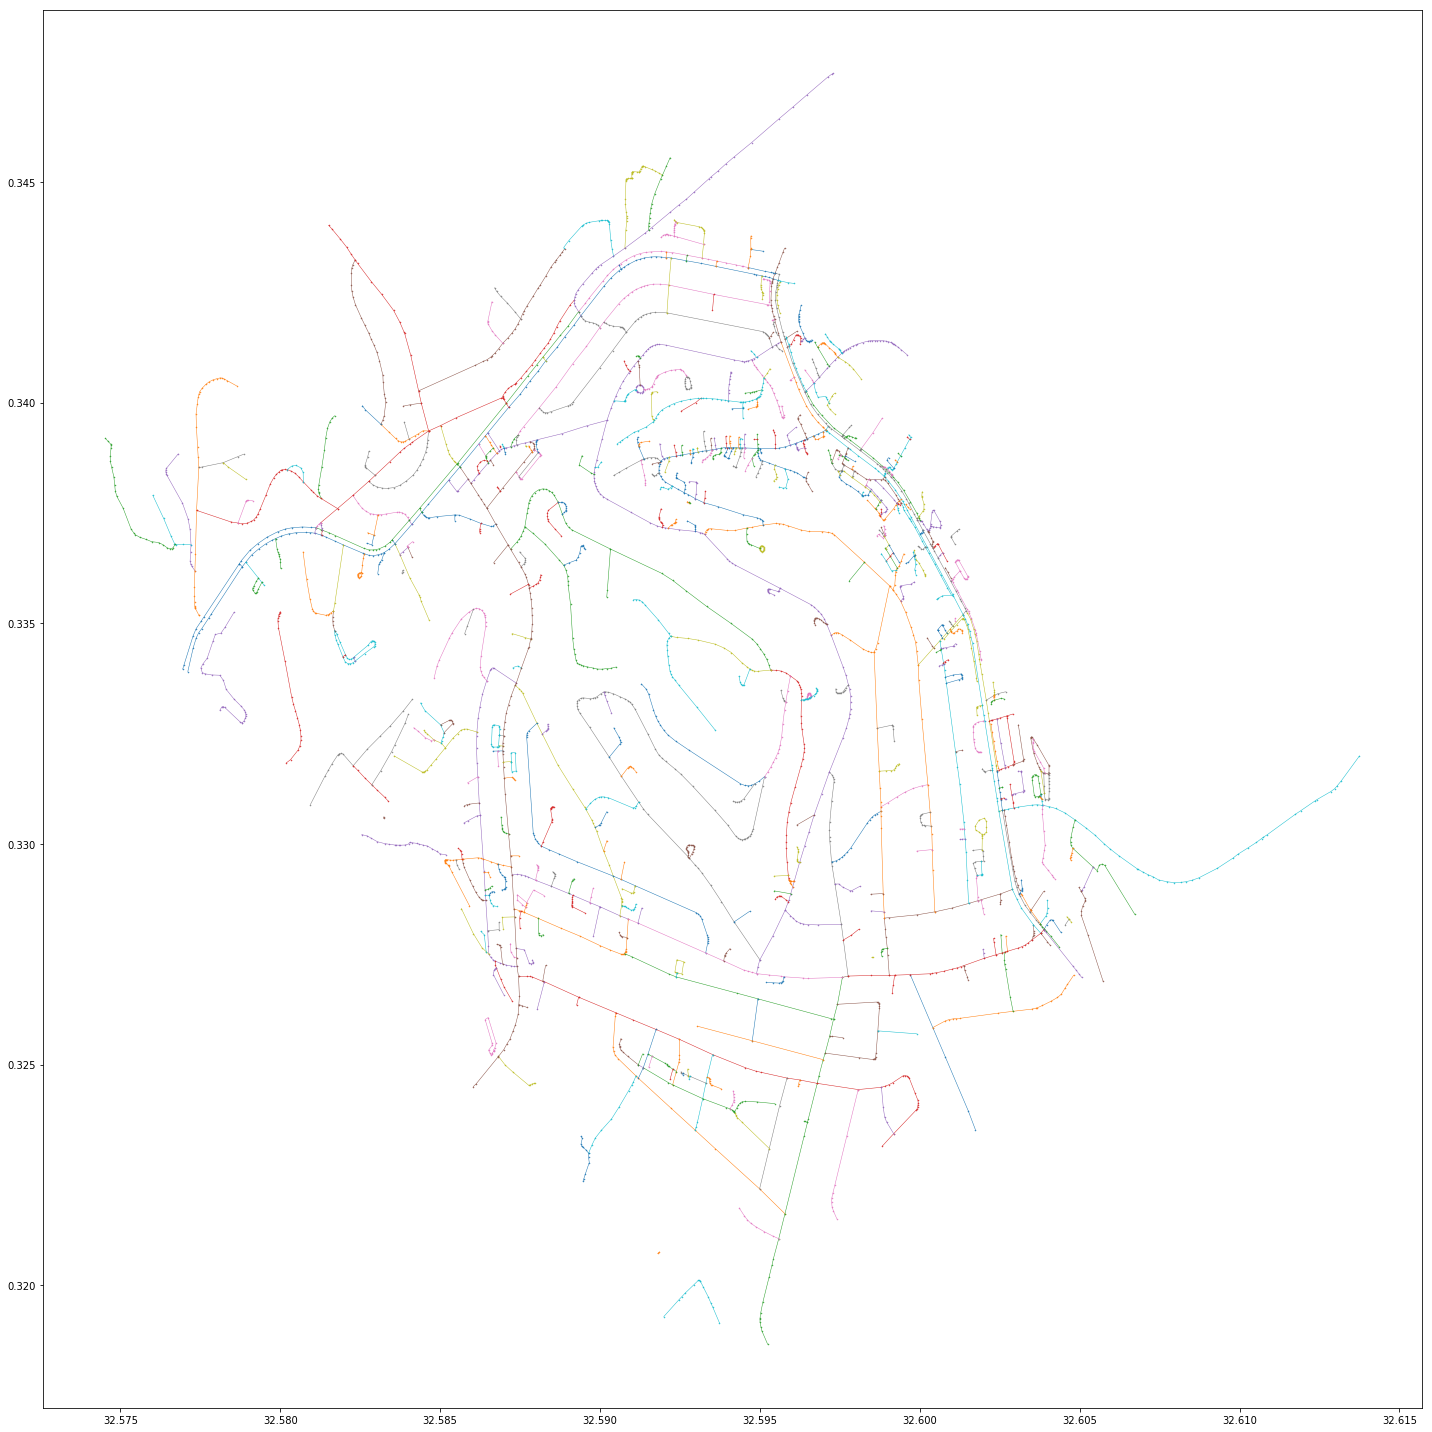

In [33]:
plt.figure(figsize=(20, 20))
# plot roads
for i in way_coord_dict_sub_sub_serialized:
    coord_list = way_coord_dict_sub_sub_serialized[i]
    lon_list = [x[1] for x in coord_list]
    lat_list = [x[0] for x in coord_list]
    plt.plot(lon_list, lat_list, linewidth=0.5, marker='.', markersize=1)
plt.tight_layout()

In [34]:
with open(join(save_dir, 'way_coord_dict_processed.pickle'), 'wb') as f:
    pickle.dump(way_coord_dict_sub_sub_serialized, f)
with open(join(save_dir, 'intersection_dict_processed.pickle'), 'wb') as f:
    pickle.dump(intersection_coords, f)

# 2. preprocessing building data

In [36]:
building_csv = pd.read_csv(join(data_dir, 'building_info/' + country + '.csv'))
len(building_csv)

5329385

In [37]:
building_list = []
for i in tqdm(building_csv.index):
    lat = building_csv.loc[i, 'centroid_lat']
    lon = building_csv.loc[i, 'centroid_lon']
    if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
        pp = Point(lon, lat)
        for j, boundary in enumerate(boundaries):
            if (boundary.contains(pp)):
                building_list.append((lat, lon))
                break
len(building_list)

100%|██████████| 5329385/5329385 [04:53<00:00, 18130.75it/s]


2995

In [39]:
with open(join(data_dir, 'building_info/africa/building_list_' + region + '.pickle'), 'wb') as f:
    pickle.dump(building_list, f)